### Data Cleaning

The goal in this notebook is to remove as much of the non-tech entries as possible. The data will not be perfect but needs to be more representative of a true proportion of the tech job landscape. 

The approach taken here is to find the 200 (somewhat arbitrarily chosen) most common job titles and remove job titles that are not directly associated with a tech position (some sort of software or productt development involved), such as "cashier" or "truck driver". The list of jobs will then be used as a guide for a text classification model. Jobs below a certain threshold of similarity (to be decided here) will be dropped from the data. 

In [59]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
jobs = pd.read_csv('indeed_jobs.csv', sep='|')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",NaN,0,Produces clear documentation for marketing pag...,30+ days ago,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",NaN,0,Supports marketing related trade shows and ven...,7 days ago,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",NaN,0,Work with hospital strategy department and mar...,13 days ago,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30+ days ago,Marketing Technologist


In [3]:
# As the data stands, the more unique job titles are
# the most likely (intuitively) to not be tech related
jobs['role'].value_counts(ascending=True)[11:31]

# MEAT MANAGER! (not helpful)

Robotic Technical Lead                                                                 1
Research Technician I                                                                  1
Substitute Teacher District Pool (Per Diem, Building, Long Term Sub) (Districtwide)    1
MAC Desktop Admin                                                                      1
Fire Protection and Life Safety Consultant                                             1
salesforce Developer 10+ Years Profiles 100% Remote job                                1
Clinical Medical Technologist (Laboratory Manager)                                     1
AutoCAD Telecommunications Technician                                                  1
Engineer | Xtream Arena & GreenState Family Fieldhouse                                 1
Assistant/Associate/Professor Dependent on Qualifications                              1
Orchestration OSS WW Senior Solution architect                                         1
Business Development 

One of the main issues is that filtering by the most common
job titles will not help the situation as too many titles
are unique. The graph below shows the amount of unique titles 
overwhelming common titles; duplicates are in the minority.

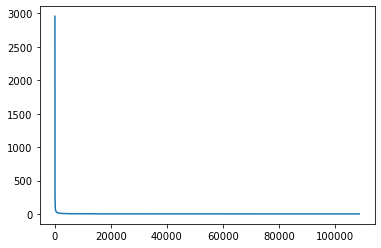

In [4]:
plt.plot(jobs['role'].value_counts().values);

In [ ]:
two_hundred_jobs = jobs['role'].value_counts()[:200].index

In [ ]:
with open("jobs_200.txt", "w") as f:
    for job in two_hundred_jobs:
        f.write("{}\n".format(job))

In [5]:
with open("tech_jobs_edited.txt", "r") as fedit:
    valid_jobs = fedit.read()
    valid_jobs = valid_jobs.split('\n')

In [6]:
def format_string(s):
    ptrn = r'[^a-zA-z]'
    new = re.sub(ptrn, ' ', s)
    new = new.replace('  ', ' ')
    new = new.strip().lower()
    
    return new

In [7]:
valid_jobs = list(map(format_string, valid_jobs))

In [8]:
# vectorize job titles and fit nearest neighbors
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             max_df=.50)
jobs_transformed = vectorizer.fit_transform(valid_jobs)
nn = NearestNeighbors(n_neighbors=1, algorithm="brute",
                      metric="cosine")
nn.fit(jobs_transformed)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=1)

In [9]:
test_jobs = jobs['role'].value_counts(ascending=True)[:50].index
test_jobs = test_jobs.to_list()
zeros = np.zeros(len(test_jobs))
test_data = {'job': test_jobs, 'distance': zeros}

In [10]:
test_df = pd.DataFrame(data=test_data)
test_df['job'] = test_df['job'].apply(format_string)
test_df.head()

,job,distance
0,social scientist biological scientist nepa pla...,0.0
1,rn clinician neurosurgery team lead,0.0
2,content project manager,0.0
3,director of digital marketing ecommerce,0.0
4,azure cloud security engineer,0.0


In [11]:
test_jobs_transformed = vectorizer.transform(test_df['job'])
distances, indices = nn.kneighbors(test_jobs_transformed)

In [12]:
test_df['distance'] = distances
test_df['neighbor'] = list(map(lambda x: valid_jobs[x[0]], indices))

In [13]:
test_df[test_df['distance'] <= .20]

,job,distance,neighbor
2,content project manager,0.199729,project manager
3,director of digital marketing ecommerce,0.167140,digital marketing manager
4,azure cloud security engineer,0.000000,cloud security engineer
10,senior product designer education,0.000000,senior product designer
11,robotic technical lead,0.000000,technical lead
16,salesforce developer years profiles remote...,0.150677,salesforce developer
44,lead product manager medtech healthtech ai at...,0.168425,product manager
48,principal product designer disney,0.194755,product designer


As seen above, there are some jobs that pass through the filter with a distance threshold of 0.35, but not many (~12% of the job listings are not accurately designated as tech jobs). It's worth the time to see how this would affect the entire dataset:

In [14]:
jobs['role_formatted'] = jobs['role'].apply(format_string)
roles_transformed = vectorizer.transform(jobs['role_formatted'])
distances, indices = nn.kneighbors(roles_transformed)
jobs['distances'] = distances
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field,role_formatted,distances
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist,lead software engineer ecommerce,0.000000
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",NaN,0,Produces clear documentation for marketing pag...,30+ days ago,Marketing Technologist,associate director of uaa student web experience,0.654724
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",NaN,0,Supports marketing related trade shows and ven...,7 days ago,Marketing Technologist,sales support coronary clinical specialist im...,0.519860
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",NaN,0,Work with hospital strategy department and mar...,13 days ago,Marketing Technologist,laboratory operations manager,0.553017
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30+ days ago,Marketing Technologist,snr key account technology engineer i epi,0.526566


In [15]:
# how much data is retained when the jobs are filtered via distance?
print(f"Data retained at .35: {jobs[jobs['distances'] < .35].shape[0]}")
print(f"Data retained at .30: {jobs[jobs['distances'] < .30].shape[0]}")
print(f"Data retained at .20: {jobs[jobs['distances'] < .20].shape[0]}")

Data retained at .35: 126286
Data retained at .30: 117809
Data retained at .20: 92291


In [16]:
jobs = jobs[jobs['distances'] < .30]
jobs['role'].value_counts()[:20]

Software Engineer            2957
Software Developer           1401
Senior Software Engineer     1395
Business Analyst             1253
Full Stack Developer         1017
Web Developer                 982
Product Manager               912
Systems Administrator         809
Systems Engineer              789
Project Manager               787
Data Analyst                  744
Marketing Manager             685
DevOps Engineer               673
Data Scientist                554
Account Manager               509
Digital Marketing Manager     503
Front End Developer           499
Social Media Manager          442
Java Developer                385
System Administrator          383
Name: role, dtype: int64

In [17]:
# The more unique roles were previously more likely to
# be related to a field other than tech. Much improved!
jobs['role'].value_counts(ascending=True)[:20]

Lead Software Engineer, Testing                                                            1
Front End Maintainer                                                                       1
Quality Assurance Review Analyst - Part-time (Winchester, VA)                              1
Business Systems Analyst -- Personnel Board of Jefferson County                            1
Lead IT Financial Analyst                                                                  1
Systems Administrator - Germany                                                            1
Maintenance Support Engineer                                                               1
Senior ADS Project Manager                                                                 1
Middle Office Business Analyst                                                             1
Senior Project Finance Developer                                                           1
QA/Testing Engineer                                                   

The figures above are an improvement from the retention seen in past attempts (trying to align the `search_field` column with job roles) and are more likely to produce a dataset where the jobs are _actually_ related to tech. Now, we can apply a process that I attemped earlier: organizing the actual job titles into uniform categories. The following section *Individual Jobs* is from the aforementioned previous attempt. The goal here is two merge the previous process with the following one to create a totally improved, albeit thinner dataset, more representative of the population of Indeed tech jobs

### Individual Jobs
An explanation of what's going on here:
>To answer the question of which jobs have more remote possibilities I'll take a look at the top 20 jobs. This will also help answer the question of average pay range per job. There is one issue, however: The `search_field` result column does not ensure that its value will be related to the `role` column. The job roles have a lot of variation in how they're named, and picking out groups manually would be an impractical waste of time. 

>The proposed method to alleviate this is to take a deterministic and a probabilistic model and use the text details of the job to classify the roles that are named with enough variation to make them appear to be different jobs. Here I will use a Multinomial Naive Bayes and a K-Nearest Neighbors to see which gets better accuracy. The winner will classify the job roles in a new column. Similarity score will also be stored. Scores below a threshold will be discarded. 

In [18]:
# First, some housekeeping: The software developer role and it's
# corresponding search field have a spelling discrepancy
jobs.loc[jobs['search_field'] == 'Software Developers', 'search_field'] = "Software Developer"

In [19]:
# Now, the jobs where the role and search_field align exactly
# will become the training data. This could be difficult to test
# because some roles only have one example
class_data = jobs[jobs['role'] == jobs['search_field']]

Because some of the roles only have one example, I'll manually choose some of the search results that align with the `search_field` job title to rename according to the target job roles. This will make it easier to create a stratified train/test split

In [20]:
class_data['role'].value_counts()[class_data['role'].value_counts() == 1]

Web Analytics Developer    1
Game Developer             1
Name: role, dtype: int64

In [21]:
# create a new column that will be used as the new label
jobs['job_label'] = jobs['role']

In [22]:
weban_data = jobs[jobs['search_field'] == 'Web Analytics Developer'][['role', 'details']].values
weban_index = jobs[jobs['search_field'] == 'Web Analytics Developer'][['role', 'details']].index

gamedev_data = jobs[jobs['search_field'] == 'Game Developer'][['role', 'details']].values
gamedev_index = jobs[jobs['search_field'] == 'Game Developer'][['role', 'details']].index

weban = list(zip(weban_data, weban_index))
gamedev = list(zip(gamedev_data, gamedev_index))

In [ ]:
for value, index in weban:
    print(value[1], index, value[0])
    print(">>>>>>>>>>>>>>>>>>>>>>")

In [33]:
jobs.loc[1186][['role', 'details']]

role          Software Developer with Strong Database Skills
details    Work part of a team that focuses on providing ...
Name: 1186, dtype: object

In [35]:
# create a dictionary to hold the indices of good matches for named roles
job_label_dict = {'Game Developer':[243469, 243470, 243485, 
                                    243486, 243511, 243519],
                  'Web Analytics Developer': [1175, 1187, 1186,
                                              1276, 4649, 4636]}

In [36]:
for job_name, indices in job_label_dict.items():
    for idx in indices:
        jobs.loc[idx, 'job_label'] = job_name

Now there should be enough data to split into train and test

In [37]:
class_data = jobs[jobs['job_label'] == jobs['search_field']][['job_label', 'details']]

#### Creating Training Data
Now the details from each job in the new training data need to be vectorized.

In [41]:
class_data['job_label'].value_counts()

Product Manager              651
Software Developer           648
Systems Engineer             578
Data Analyst                 490
Data Scientist               480
Systems Administrator        475
Database Administrator       273
Digital Marketing Manager    235
Business Systems Analyst     190
Social Media Manager         168
Data Architect               164
UX Designer                  132
Technical Account Manager    123
Python Developer             102
Cloud Architect               91
Technical Lead                86
Front-End Developer           45
Content Manager               42
Mobile Developer              41
WordPress Developer           35
UI Designer                   34
Agile Project Manager         30
Ruby on Rails Developer       25
Mobile App Developer          21
Full-Stack Developer          19
Web Analytics Developer        7
Game Developer                 7
Name: job_label, dtype: int64

In [42]:
# accuracy in predictions may increase if the job_label is adds to the description
class_data['details'] = class_data['job_label'] + ' ' + class_data['details'] 

In [43]:
def format_text(series, inplace=False):
    """Format text in a way that optimizes vectorization"""
    if not inplace:
        series = series.copy()
    series = series.str.replace('[^a-zA-Z0-9]', ' ')
    series = series.str.replace('\s{2}', ' ')
    series = series.str.lower().str.strip()
    
    return series

In [44]:
documents = format_text(class_data['details'])

In [45]:
documents.iloc[3999]

'data scientist our data scientists serve as subject matter experts on healthcare quality measurement and risk adjustment use predictive modeling to identify patient'

In [48]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                             max_df=.80, min_df=10)
le = LabelEncoder()
le.fit(class_data['job_label'])

X = vectorizer.fit_transform(documents)
y = le.transform(class_data['job_label'])

In [49]:
print(X.shape)
print(y.shape)

(5192, 2680)
(5192,)


In [52]:
# split X into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4153, 2680) (1039, 2680)
(4153,) (1039,)


In [60]:
neighbors = KNeighborsClassifier(algorithm="brute", metric="cosine")
neighbors.fit(X_train, y_train)

n_bayes = MultinomialNB(alpha=0.1)
n_bayes.fit(X_train, y_train)

y_pred_neighbors = neighbors.predict(X_test)
y_pred_n_bayes = n_bayes.predict(X_test)
print(f"KNeighbors: {accuracy_score(y_test, y_pred_neighbors)}")
print(f"MultinomialNB: {accuracy_score(y_test, y_pred_n_bayes)}")

KNeighbors: 0.9133782483156881
MultinomialNB: 0.9153031761308951


In [61]:
jobs['role_plus_details'] = jobs['role'] + ' ' + jobs['details']
jobs['role_plus_details'] = format_text(jobs['role_plus_details'])
jobs[['role', 'search_field', 'role_plus_details']]

,role,search_field,role_plus_details
0,Lead Software Engineer - eCommerce,Marketing Technologist,lead software engineer ecommerce our advanced...
6,Snr Key Account Technology Engineer II - ALD,Marketing Technologist,snr key account technology engineer ii ald re...
8,Salesforce Developer - US Delivery Center,Marketing Technologist,salesforce developer us delivery center build...
11,Lead Software Engineer - eCommerce,Marketing Technologist,lead software engineer ecommerce our advanced...
12,UI/UX Designer-Clearance Required,Marketing Technologist,ui ux designer clearance required we implement...
...,...,...,...
248004,"Part-Time, IT: Software Developer Instructor",Mobile App Developer,part time it software developer instructor net...
248005,Senior Salesforce Developer,Mobile App Developer,senior salesforce developer in addition we als...
248006,Software Development Engineer - iOS,Mobile App Developer,software development engineer ios 3 years exp...
248007,Senior Principal Software Engineer,Mobile App Developer,senior principal software engineer mobile app ...


In [62]:
desc = jobs['role_plus_details'].iloc[23094]
print(desc)
desc = vectorizer.transform([desc])
le.inverse_transform(n_bayes.predict(desc))

front end developer integrate data from various back end services including api and databases translation of the ui ux design wireframes to actual code that will produce visual


array(['Front-End Developer'], dtype=object)

In [63]:
descriptions = jobs['role_plus_details']
descriptions = vectorizer.transform(descriptions)
descriptions = n_bayes.predict(descriptions)
jobs['predicted_role'] = le.inverse_transform(descriptions)

In [65]:
# top ten before label prediction
for rank, role in enumerate(jobs['role'].value_counts()[:10].index):
    print(f"{rank+1}. {role}")

1. Software Engineer
2. Software Developer
3. Senior Software Engineer
4. Business Analyst
5. Full Stack Developer
6. Web Developer
7. Product Manager
8. Systems Administrator
9. Systems Engineer
10. Project Manager


In [66]:
# top ten after label prediction
for rank, role in enumerate(jobs['predicted_role'].value_counts()[:10].index):
    print(f"{rank+1}. {role}")

1. Software Developer
2. Systems Engineer
3. Product Manager
4. Data Analyst
5. Systems Administrator
6. Business Systems Analyst
7. UX Designer
8. Data Scientist
9. Digital Marketing Manager
10. Technical Account Manager


In [72]:
jobs[jobs['predicted_role'] == "Data Scientist"][['role', 'predicted_role','search_field']].head()

,role,predicted_role,search_field
134,"Staff Software Engineer, Fullstack",Data Scientist,Marketing Technologist
396,Data Scientist,Data Scientist,Marketing Technologist
405,Data Scientist - Artificial Intelligence - Rad...,Data Scientist,Marketing Technologist
477,Data Analyst,Data Scientist,Marketing Technologist
499,Product Designer,Data Scientist,Marketing Technologist


In [75]:
jobs[jobs['predicted_role'] == "Front-End Developer"][['role', 'predicted_role','search_field']].head()

,role,predicted_role,search_field
35,Front-end Web Developer,Front-End Developer,Marketing Technologist
656,Front End/UI Developer (110939),Front-End Developer,Marketing Technologist
1146,Front End Solutions Developer,Front-End Developer,SEO Consultant
1304,Front End Web Developer,Front-End Developer,Web Analytics Developer
1306,Front-end Web Developer,Front-End Developer,Web Analytics Developer


In [79]:
jobs[jobs['predicted_role'] == "UI Designer"][['role', 'predicted_role','search_field']].head(10)

,role,predicted_role,search_field
3378,Wealth Management Technology - Senior UI/UX De...,UI Designer,Web Analytics Developer
14788,UX Designer,UI Designer,Content Manager
35925,UI Designer,UI Designer,UX Designer
35947,Lead UX/UI Designer,UI Designer,UX Designer
35969,UI Designer,UI Designer,UX Designer
35992,Mobile Game UX/UI Designer,UI Designer,UX Designer
36047,UX/UI Designer,UI Designer,UX Designer
36223,UI Designer,UI Designer,UX Designer
36271,Web Designer,UI Designer,UX Designer
36373,Web Designer/Developer,UI Designer,UX Designer


In [80]:
jobs[jobs['predicted_role'] == "Mobile App Developer"][['role', 'predicted_role','search_field']].head()

,role,predicted_role,search_field
1522,Hybrid Mobile App Developer,Mobile App Developer,Web Analytics Developer
2024,MASTER MOBILE APP DEVELOPER,Mobile App Developer,Web Analytics Developer
47998,Mobile App Developer Intern,Mobile App Developer,Front-End Developer
48339,Mobile App Developer,Mobile App Developer,Front-End Developer
50058,App Developer,Mobile App Developer,Front-End Developer


As we can see from the examples above, the `search_field` column (created during scrape) did not always align with the actual role. After removing jobs that were not likely to be tech-related and categorizing them using the description snippets, we end up with data that, while not perfect, provides a far better representation of the job landscape.

In [82]:
jobs.to_csv('jobs_cleaned.csv', sep='|', index=False)